In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
from utils import ExchangeRatesReader
import statsmodels.api as sm

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
!pip3 install xlrd

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
reader = ExchangeRatesReader('./er_daily_2010-present.xls')

In [5]:
df = reader.to_dataframe()

In [6]:
df.head()

EUR  KZT  RUB      USD                дата*
2010 0  NaN  NaN  NaN  44.0917  2010-01-01 00:00:00
     1  NaN  NaN  NaN  44.0917  2010-01-04 00:00:00
     2  NaN  NaN  NaN  44.0917  2010-01-05 00:00:00
     3  NaN  NaN  NaN  44.0917  2010-01-06 00:00:00
     4  NaN  NaN  NaN  44.0917  2010-01-07 00:00:00

In [7]:
df.rename(columns={'дата*': 'date'}, inplace=True)

In [8]:
# need to remove all junk strings from the file
# TODO: this can be done in one function
def clean_junk_string(dataframe, column, inplace=False):
    print('Removing {} bad rows...'.format(dataframe[column].apply(lambda x: isinstance(x, str)).sum()))
    
    if inplace:
        return dataframe.drop(get_bad_indexes(dataframe[column]), inplace=True)
    else:
        return dataframe.drop(get_bad_indexes(dataframe[column]), inplace=False)

def get_bad_indexes(series):
    series_is_string = series.apply(lambda x: isinstance(x, str))
    series_non_string = series[series_is_string == True]
    return series_non_string.index

In [9]:
clean_junk_string(df, 'date', inplace=True)

Removing 25 bad rows...


In [10]:
df.index = df['date']

In [11]:
df.head()

,EUR,KZT,RUB,USD,date
date,,,,,
2010-01-01,NaN,NaN,NaN,44.0917,2010-01-01 00:00:00
2010-01-04,NaN,NaN,NaN,44.0917,2010-01-04 00:00:00
2010-01-05,NaN,NaN,NaN,44.0917,2010-01-05 00:00:00
2010-01-06,NaN,NaN,NaN,44.0917,2010-01-06 00:00:00
2010-01-07,NaN,NaN,NaN,44.0917,2010-01-07 00:00:00


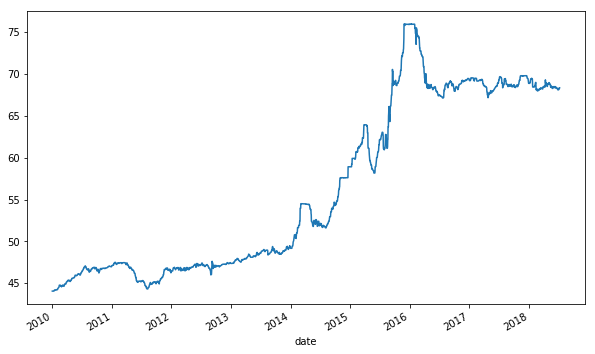

In [12]:
plt.figure(figsize=(10,6))
df['USD'].plot()

In [13]:
# Let's start with the basic smoothing
def moving_average(series, n):
    return np.average(series[-n:])

In [14]:
moving_average(df['USD'], 20)

68.20911000000001

In [15]:
def plot_moving_average(series, n):
    """ n - smoothing period """
    
    ma_series = []
    for i in range(series.shape[0]):
        res = moving_average(series[:i], n)
        ma_series.append(res)
        
    plt.plot(df['date'], ma_series, 'r')

In [16]:
def plot_moving_average_pandas_interface(series, n):
    """ n - smoothing period """
    
    
        
    plt.plot(df['date'], series.rolling(n).mean(), 'r')

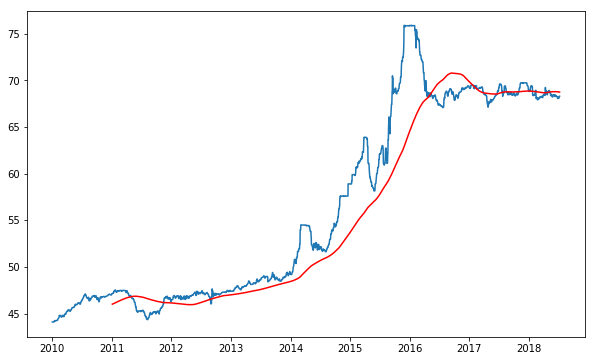

In [17]:
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['USD'])
plot_moving_average_pandas_interface(df['USD'], 365)

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


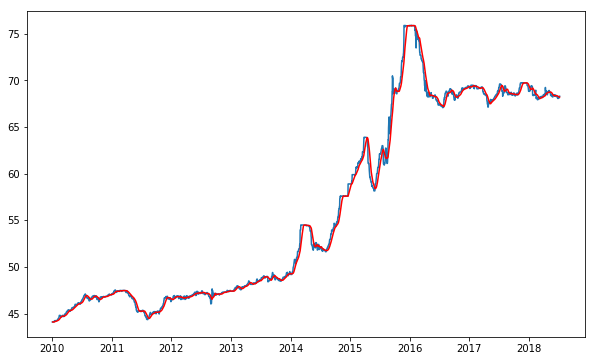

In [18]:
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['USD'])
plot_moving_average(df['USD'], 20)

## Double exponential smoothing (taking trend into account)

In [19]:
def double_exp_smoothing(series, alpha, beta): ## TODO: rewrite this to return a series, convenient for plotting
    """ predict series taking its trend into account
        alpha - smoothing factor
        beta - trend smoothing
    """
    level = 0
    trend = 0
    
    for i in range(series.shape[0]):
        if i == 0:
            level = alpha * series[i]
        else:
            level_prev = level
            level = alpha * series[i] + (1 - alpha) * (level + trend)
            trend = beta * (level - level_prev) + (1 - beta) * trend
    
    predicted = level + trend
    return predicted

In [20]:
double_exp_smoothing(df['USD'], 0.7, 0.7)

68.33571966466387

In [21]:
def double_exponential_smoothing_from_habr(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [22]:
double_exponential_smoothing_from_habr(df['USD'], 0.7, 0.7)[-2]

68.33571966466387

In [33]:
def plot_dexp_smoothing(series, alpha, beta):
    """ plots a double exponentially
    smoothed series
    n - smoothing period """
    
    predicted_series = []
    for i in range(series.shape[0]):
        res = double_exp_smoothing(series[:i+1], alpha, beta)
        predicted_series.append(res)
        
    plt.plot(df['date'], predicted_series, 'r')

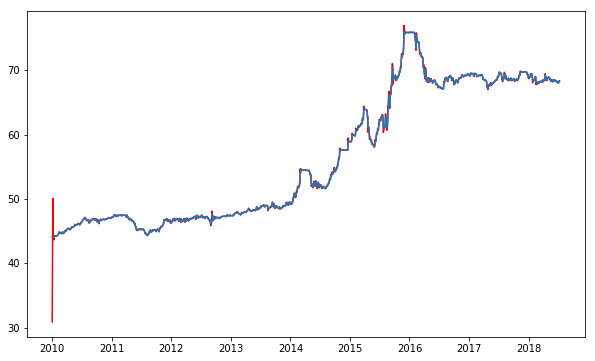

In [24]:
plt.figure(figsize=(10,6))
plot_dexp_smoothing(df['USD'], 0.7, 0.7)
plt.plot(df['date'], df['USD'])

## ARIMA

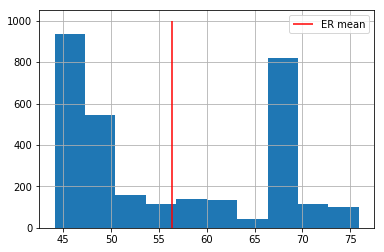

In [34]:
df['USD'].hist()
plt.vlines(df['USD'].mean(), 0, 1000, colors='r', label='ER mean')
plt.legend()

#### Coefficient of variation

In [35]:
print("{:.4f}".format(df['USD'].std() / df['USD'].mean()))

0.1820


We observe the large variance here relative to the series mean.

In [36]:
# Let's check stationarity of our series using Augmented Dickey-Fuller test
adfuller = sm.tsa.adfuller(df['USD'])
print('ADF: {:4f}'.format(adfuller[0]))
print('p-value: {:4f}'.format(adfuller[1]))
print('critical values: {}'.format(adfuller[4]))

if adfuller[0] > adfuller[4]['5%']:
    print('Series is not stationary')

else:
    print('Series is stationary')

ADF: -0.871246
p-value: 0.797294
critical values: {'5%': -2.8624791618529764, '1%': -3.4324756122601006, '10%': -2.5672699390416343}
Series is not stationary


In [37]:
er1diff = df['USD'].diff(periods=1).dropna()
er1diff.index = df['date'].index[1:]

In [38]:
adfuller = sm.tsa.adfuller(er1diff)
print('ADF: {:4f}'.format(adfuller[0]))
print('p-value: {:4f}'.format(adfuller[1]))
print('critical values: {}'.format(adfuller[4]))

if adfuller[0] > adfuller[4]['5%']:
    print('Series is not stationary')

else:
    print('Series is stationary')

ADF: -7.915132
p-value: 0.000000
critical values: {'5%': -2.8624791618529764, '1%': -3.4324756122601006, '10%': -2.5672699390416343}
Series is stationary


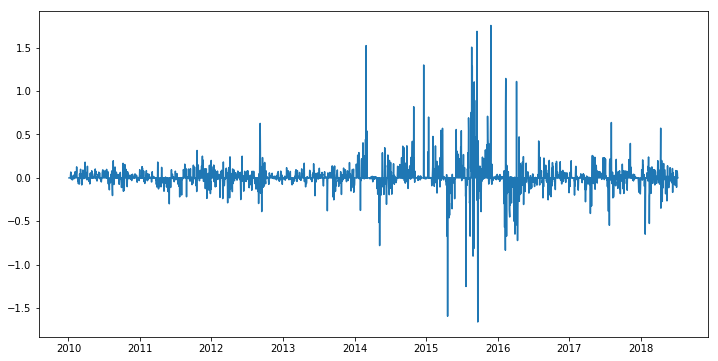

In [39]:
# Let's confirm stationarity of the 1st lag differences
plt.figure(figsize=(12,6))
plt.plot(df['date'][1:], er1diff)

In [40]:
# Let's compare the means to prove statioanarity in the first-lag differences
er1diff_part1 = er1diff['2010':'2014']
er1diff_part2 = er1diff['2015':'2018']
d1 = sm.stats.DescrStatsW(er1diff_part1)
d2 = sm.stats.DescrStatsW(er1diff_part2)

print('p-value: {}'.format(sm.stats.CompareMeans(d1,d2).ttest_ind()[1]))

p-value: 0.8761075499788329


The p-value for the null hypothesis of two means being equal can not be rejected. So, we can now say that our series is stationary. This is supported further by the absence of a trend on the graph above.
Thus, our original exchange rate series is a difference-stationary 1st-order series.

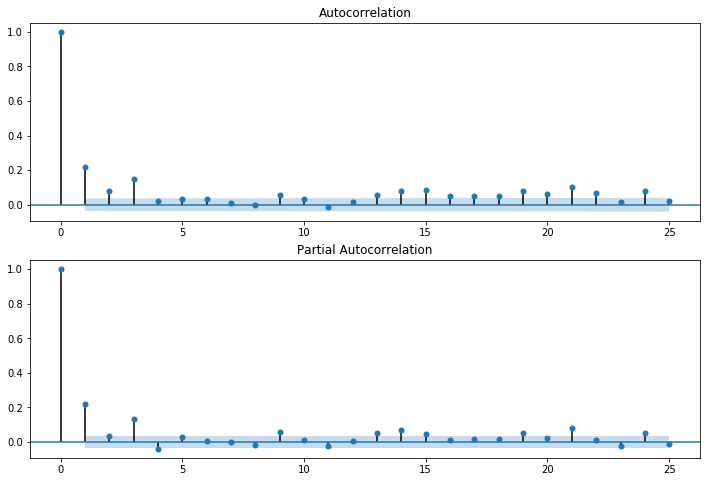

In [41]:
# We now turn to ARIMA(p,d,q) ,where we have found d already. d = 1 from the above
# To continue, we need p and q. For this, we will plot autocorrelation function and partial autocorrelation function.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(er1diff.values, lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(er1diff.values, lags=25, ax=ax2)

We now see that our p = 1 and q = 1.

In [42]:
train = df['USD']['2010':'2016']
arima = sm.tsa.ARIMA(train, order=(1,1,1), freq='D')
arima = arima.fit()

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


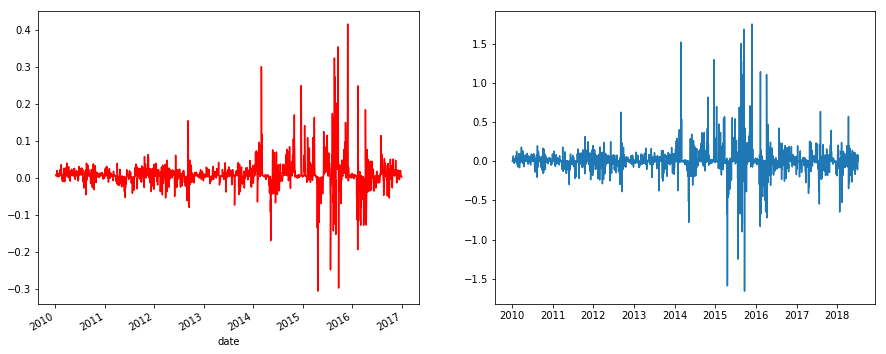

In [51]:
plt.figure(figsize=(15,6))
plt.subplot(121)
arima.fittedvalues.plot(c='r')
plt.subplot(122)
plt.plot(df['date'][1:], er1diff)

In [ ]:
print(arima.summary())

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


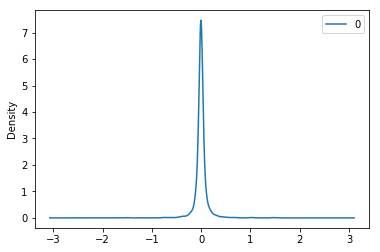

In [54]:
residuals = pd.DataFrame(arima.resid)
residuals.plot(kind='kde')

In [28]:
residuals.describe()

,0
count,2550.000000
mean,0.000002
std,0.145821
min,-1.685407
25%,-0.024415
50%,-0.006887
75%,0.014958
max,1.607526


In [65]:
predicted = arima.predict(start='2016-01-01', end='2016-12-31', typ='levels')

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [66]:
predicted_outOfSample = arima.forecast(steps=365)[0]

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [67]:
predicted_outOfSample = pd.Series(predicted_outOfSample, index=df['USD']['2017'].index)

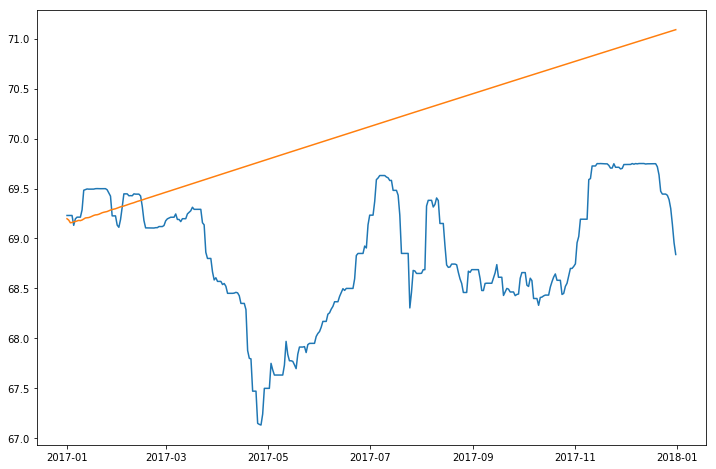

In [68]:
plt.figure(figsize=(12,8))
plt.plot(df['USD']['2017'])
plt.plot(predicted_outOfSample)

As we see from the above, ARIMA(1,1,1) forecasts a straight line which is incorrect.

In [568]:
predicted_outOfSample_ = arima.predict(start='2016-01-01', end='2016-12-31')

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


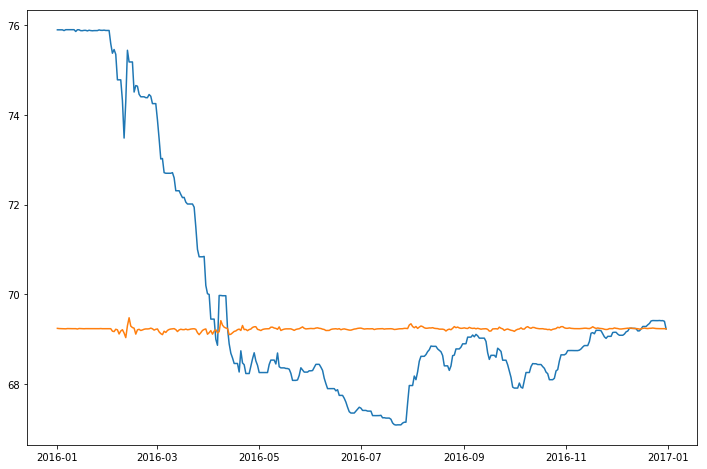

In [575]:
plt.figure(figsize=(12,8))
plt.plot(df['USD']['2016'])
plt.plot(predicted_outOfSample_)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


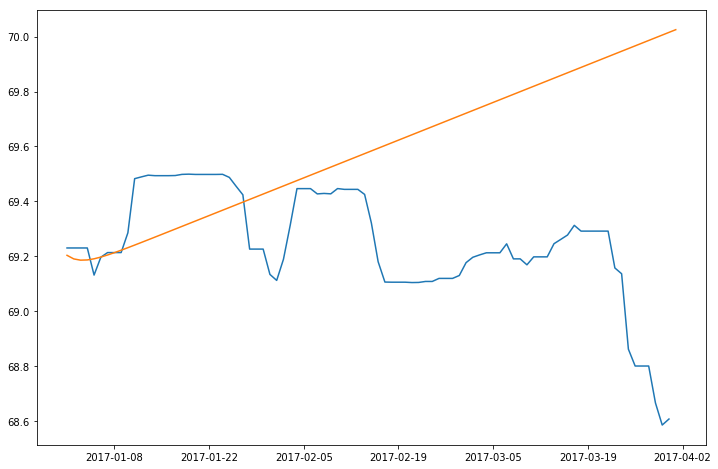

In [602]:
predicted_outOfSample_stationary = arima.predict(start=len(train), end=len(train)+90, typ='levels')

# predicted_restored = []
# for i in predicted_outOfSample_stationary:
#     res = inverse_difference(train, i, 1)
#     predicted_restored.append(res)

# predicted_restored = pd.Series(predicted_restored, index=df['USD'].index[len(train):len(train)+31])    

plt.figure(figsize=(12,8))
plt.plot(df['USD']['2017'][:90])
# plt.plot(predicted_restored)
plt.plot(predicted_outOfSample_stationary)

In [413]:
# forecast_365days = arima.forecast(steps=365)[0]

In [414]:
# plt.figure(figsize=(12,8))
# plt.plot(df['date'], df['USD'])
# plt.plot(df['date']['2017':].iloc[:365], forecast_365days)

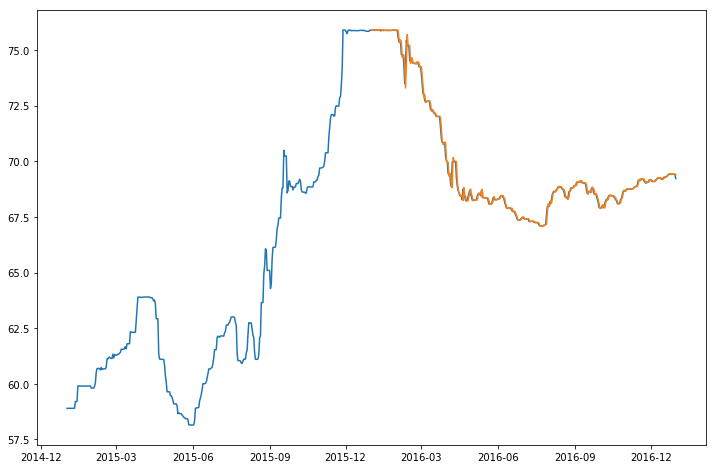

In [491]:
plt.figure(figsize=(12,8))
plt.plot(df['USD'].loc['2015':'2016'])
plt.plot(predicted)

In [389]:
# test_predicted = arima.forecast(steps=100)[0]

In [490]:
# plt.figure(figsize=(12,8))
# plt.plot(df['date'].loc['2017':'2018'], df['USD'].loc['2017':'2018'])
# plt.plot(df['date'].loc['2017':'2018'].iloc[:100], test_predicted)

In [526]:
# rolling ARIMA forecasting of the exchange rate (model is refit each time a new observation is added)

def rolling_arima(train, test, params):
    """ returns rolling ARIMA estimates with each new data point added and the model refit
        train - initial data to fit ARIMA
        test - test data from which data points are added one by one and the model is refit
        params - tuple with ARIMA params (ARIMA(p,d,q))"""
    
    history = [x for x in train]
    rolling_predictions = []

    for i in range(len(test)):
        arima_model = sm.tsa.ARIMA(history, order=params, freq='D')
        arima_fit = arima_model.fit(disp=0)
        forecasted = arima_fit.forecast()[0]
        rolling_predictions.append(forecasted)
        obs = test[i]
        history.append(obs)
#         print(forecasted)
    
    return pd.Series(rolling_predictions, index=test.index)

In [527]:
%%time
rolling_predictions = rolling_arima(df['USD'][:'2016'], df['USD']['2017':], (1,1,1))

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


CPU times: user 3min 36s, sys: 2min 51s, total: 6min 27s
Wall time: 3min 14s


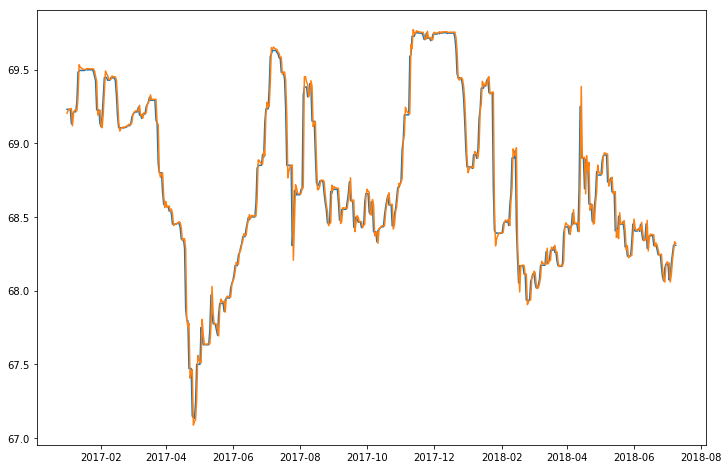

In [528]:
plt.figure(figsize=(12,8))
plt.plot(df['USD']['2017':])
plt.plot(rolling_predictions)

In [407]:
# np.array(predictions).reshape(-1) - df['USD']['2016':]

In [290]:
def difference(series, period):
    """ returns a differenced series """
    differenced = []
    
    for i in range(1, len(series)):
        diff = series[i] - series[i - period]
        differenced.append(diff)
    
    return np.array(differenced)

def inverse_difference(series, forecasted, period):
    """ transforms differenced back to an original array """
    return forecasted + series[-period]

In [368]:
first_differences = difference(partial_series, 365)

In [373]:
arima = sm.tsa.ARIMA(first_differences, order=(1,1,1), dates=df['date']['2010':'2016'], freq='D')
arima_fit = arima.fit()

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [374]:
predicted = arima_fit.predict(start=pd.to_datetime('2016-12-31'), end=pd.to_datetime('2018-12-31'))

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [375]:
predicted_inverse = inverse_difference(partial_series, predicted, 365)

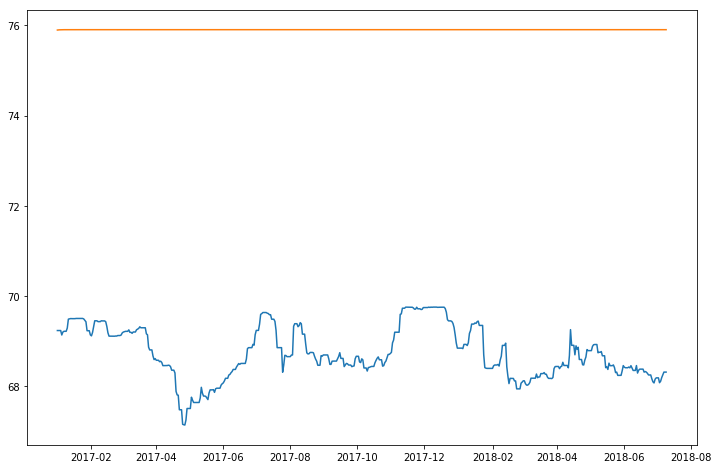

In [376]:
plt.figure(figsize=(12,8))
plt.plot(df['date'].loc['2016-12-31':], df['USD'].loc['2016-12-31':])
plt.plot(df['date'].loc['2016-12-31':], predicted_inverse[:555])

In [377]:
arima = sm.tsa.ARIMA(partial_series, order=(1,1,1), dates=df['date']['2010':], freq='D')
arima = arima.fit()

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [ ]:
## things to add
# 1. box plot (capture seasonality around months)
# 2. plot correlation of the series with its lags
# 3. try log transformation of the series
# 4 .it is also possible to estimate the trend and take it out of the series

## SARIMA aka Seasonal ARIMA

In [ ]:
#SARIMA
sarima = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,0,100))
sarima_results = sarima.fit()

In [97]:
predicted = sarima_results.predict(train.shape[0]-1, end=train.shape[0] + 200, typ='levels')
# predicted = sarima_results.forecast(steps=365)[0]
predicted.index = df['USD']['2017'][:predicted.shape[0]].index

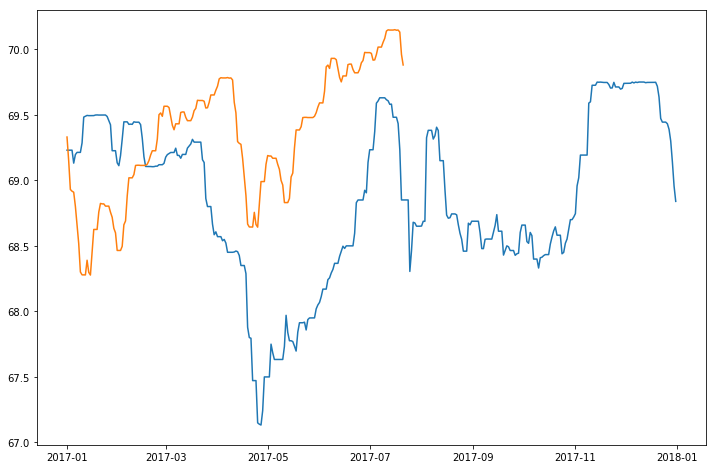

In [98]:
plt.figure(figsize=(12,8))
plt.plot(df['USD']['2017'])
plt.plot(predicted)

In [ ]:
## TO DO: tune parameters for sarima